<a href="https://colab.research.google.com/github/PavelDudarin/IBS-ULSTU/blob/master/20201013_TS_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO
1. Понять какой способ нормализации нужно применять (сейчас никакой не используется)
3. Научиться сохранять сеть (у нее есть кажется метод dump или save), и чтобы можно было провести обучения, а через какое то время загрузить сеть и продолжить исследование
4. Нужно сохранять список ts_list чтобы тоже можно было позже возвращаться к анализу этого массива
5. Добавляем пре-валидацию временного ряда, чтобы не учиться на всех примерах подряд. Цель снизить значения в ячейках (Unknown,Buy) и (Unknown,Sell) - идеи по алгоритмам валидации накидаем позже, для начала как вариант проверять достигал ли временной ряд значения 3*delta на историческом периоде.
6. Придумать как обрабатывать Volume и вернуть его.



-----------------
2. Написать процедуру (или адаптировать текущую), чтобы можно было строить DataSet для Сашиных примеров, далее этот датасет нужно научиться передавать нейронке (скорее всего через вызов метода predict у нее) и получать результаты. На выходе по каждому примеру нам нужно факт, прогноз сети, прогноз Саши, тикер, дату, класс, ну и какой то индекс - оценка качества проогноза сети в данном кейсе (пока на уровне попали или не попали, и куда в факт или в Сашу :) )


## Установка необходимых пакетов

In [1]:
!pip install -U fastai
# !pip install git+https://github.com/ai-fast-track/timeseries.git
!pip install git+https://github.com/williamsdoug/timeseries
!pip install yfinance

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.16)
  Cloning https://github.com/williamsdoug/timeseries to /tmp/pip-req-build-bo696yvu
  Running command git clone -q https://github.com/williamsdoug/timeseries /tmp/pip-req-build-bo696yvu
  Created wheel for timeseries: filename=timeseries-0.0.6-cp36-none-any.whl size=881480 sha256=9ba75dbd351d142f6a317498f6e737170658ab665592cc26458c19cb2240366c
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqh3_6ch/wheels/ad/cb/a6/44108c9a3b20d015cdc75bf2dfd7342238c5b18cfd33a09a26
Successfully built timeseries


## Импорт библиотек

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.basics import *
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")
from timeseries.all import *
import yfinance as yf
import datetime

In [3]:
# Подключаем папку с Гугл драйва
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# подключаем модули для работы с гугл-таблицами
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Глобальные переменные

In [5]:
# Фиксируем все глобальные переменные
n = 120 # число точек в хвосте временного ряда
k = 10 # число точек на которых рассчитывается класс временного ряда

delta = 0.07  # линия stop loss и 3*delta - линия take profit 
interval = '1d' # интервал между точками – [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1d, 5d, 1wk, 1mo, 3mo]

start_date = datetime.date(2020, 10, 1)
step_d = 5 # шаг по датам от start_date назад чтобы порождать временные ряды
cnt_d = 300 # количество порождаемых дат (назад от start_date) = количество временных рядов на один тикер

# Паша
ts_train_fname = '/content/drive/My Drive/20201013_TS_Stocks/'+'20201018_train.arff'
ts_test_fname = '/content/drive/My Drive/20201013_TS_Stocks/'+'20201018_test.arff'

# Аня
# ts_train_fname = '/content/drive/My Drive/Data Science/stock/20201023_train.arff'
# ts_test_fname = '/content/drive/My Drive/Data Science/stock/20201023_test.arff'

dsname = 'FINHIST'
input_fname = 'https://docs.google.com/spreadsheets/d/14uMgbrBdPtXFgIwY_GGKk7D6xBQ8cU1dxXMTXQZbrJQ/edit#gid=0' # ссылка на Google-таблицу с исходными данными

## Получение данных

### Получение списка тикеров

In [6]:
def get_tickers(gc, input_fname, sheet_name):
  wb = gc.open_by_url(input_fname)
  sheet = wb.worksheet(sheet_name)
  data = sheet.get_all_values()

  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df.iloc[1:]

  # df = df[df.human_class != '#N/A']
  return df[df.ticker != '']

### Генерация ARFF

In [7]:
def generate_arff(p_output_filename, p_ts_list):
  dimensions = []
  # tickers_list = []
  for col in p_ts_list[0][0].columns:
    dimensions.append(col)
  
  # tickers_list.append(col[0])
  
  # dimensions = list(dict.fromkeys(dimensions))
  # tickers_list = list(dict.fromkeys(tickers_list))

  with open(p_output_filename, "w") as fp:
    fp.write('''% This data was received from Yahoo Finance.
%
% Data has the following dimensions:
''')

    i = 1
    for d in dimensions:
      fp.write("% {}. {}\n".format(i, d))
      i+=1
    
    fp.write('''%
% The three classes are separate actions with the following meaning:
% 0. Unknown
% 1. Buy
% -1. Sell
%
%
@RELATION '{}'

@ATTRIBUTE relationalAtt relational
'''.format(dsname))

    for ts in range(n):
      fp.write("@ATTRIBUTE att{} numeric\n".format(ts))
    
    fp.write('''@END relationalAtt
@ATTRIBUTE classAttribute {-1,0,1}

@DATA
''')
    for ts in p_ts_list:
    # for t in tickers_list:
      line = ""
      for d in dimensions:
        for val in ts[0][d]:
          line += str(val) + ','
        line = line[:-1] + '\\n'
      line = "'"+line[:-3]+"',"+str(ts[1])  # ts[1] - class
      fp.write(line+'\n')

### Скачивание данных и генерация файла

In [8]:
def get_head_tail(stock_data, d_date):
  df_tail = pd.DataFrame(columns=stock_data.columns)
  df_head = pd.DataFrame(columns=stock_data.columns)

  d_indexes = stock_data.index[stock_data['Date'] == d_date]
  if len(d_indexes) != 0:
    d_ind = d_indexes[0]
    # набираем хвост нужной длины
    d_ind_from = d_ind - n
    d_ind_to = d_ind + k + 1
    df_tail = stock_data.iloc[d_ind_from:d_ind]
    df_head = stock_data.iloc[d_ind:d_ind_to]
  return df_tail, df_head

def normalize_ts(p_df_tail_tk, p_med):   
  # функция нормализует временной ряд (используя медиану и максимальное отклонение)

  # Временно убираем Volume (пока не пидумаем как его нормировать)
  p_df_tail_tk = p_df_tail_tk.drop(columns=['Volume'])

  max = p_df_tail_tk['High'].max()
  min = p_df_tail_tk['Low'].min()
  # print(max, min)

  for col in p_df_tail_tk.columns:
    # print(col)
    p_df_tail_tk[col] = (p_df_tail_tk[col] - p_med) / (max-min)

  return p_df_tail_tk

def append_ts_list_with_validation(p_ts_elements, p_df_tail_tk, p_class, p_tiker, p_d_date, p_price, p_tp, p_sl):
  # функция может не вставить временной ряд для обучения если он не подходит под параметры бизнес-стратегии
  # в конце вызывается функция нормализации временного ряда (перед вставкой)
  # Проверка в случае Buy
  if (p_class == 1) and (p_df_tail_tk['High'].max() - p_tp) < -1E-10:
    # print(p_df_tail_tk['High'].max() - p_tp)
    return  # значение не достигалось и мы его не добавляем

  # Проверка в случае Sell
  if (p_class == -1) and (p_tp - p_df_tail_tk['Low'].min()) < -1E-10:
    # print(p_tp - p_df_tail_tk['Low'].min())
    return  # значение не достигалось и мы его не добавляем
  p_ts_elements.append([normalize_ts(p_df_tail_tk, p_price), 
                        p_class, p_tiker, p_d_date, p_price, p_tp, p_sl
                        ]
                       )


def get_ts_elements(stock_data, df_tickers, d_date, n, k, delta, ds_type):
  ts_elements = []
  if ds_type == 'train':
    df_tail, df_head = get_head_tail(stock_data, d_date)

  if (ds_type == 'train' and not(df_tail.empty)) or (ds_type == 'val'):
    # for tk in tickers:
    for n, row in df_tickers.iterrows():
      tk = row['ticker']
      if ds_type == 'val':
        d_date = datetime.datetime.strptime(row['decision_date'], "%Y-%m-%d").date()
        df_tail, df_head = get_head_tail(stock_data, d_date)
      cl = 0  # unknown
      df_tail_tk = df_tail[tk].reset_index(drop=True)
      df_head_tk = df_head[tk].reset_index(drop=True)
      if df_tail_tk[df_tail_tk['Volume'].isna()].empty and df_head_tk[df_head_tk['Volume'].isna()].empty:
        # осталось разбораться с классом
        # проверяем гипотезу на Buy (class = 1)
        p = df_head_tk.iloc[0]['Low']+(2/3)*(df_head_tk.iloc[0]['High']-df_head_tk.iloc[0]['Low'])
        tp = p*(1+3*delta)
        sl = p*(1-delta) 
        df_sl_seek = df_head_tk.iloc[1:k]
        # в случае если stop_loss не достигается, то мы берем для рассмотрения весь интервал времени и значит индекс конца равен k+1
        sl_ind = (list(df_sl_seek.index[df_sl_seek['Low'] <= sl])+[k+1])[0]
        df_tp_seek = df_head_tk.iloc[1:sl_ind]
        is_to_buy = not(df_tp_seek[df_tp_seek['High'] >= tp].empty)
        if is_to_buy:
          cl = 1
          ts_elements.append([df_tail_tk, cl, tk, d_date, p, tp, sl])
          # print("BUY", tk)
        # print(is_to_buy)
        # проверяем гипотезу на Sell (class = -1)
        p = round(df_head_tk.iloc[0]['Low']+(1/3)*(df_head_tk.iloc[0]['High']-df_head_tk.iloc[0]['Low']),2)
        sl = round(p*(1+delta),2)
        tp = round(p*(1-3*delta),2)
        # print(sl, tp)
        df_sl_seek = df_head_tk.iloc[1:k]
        # в случае если stop_loss не достигается, то мы берем для рассмотрения весь интервал времени и значит индекс конца равен k+1
        sl_ind = (list(df_sl_seek.index[df_sl_seek['High'] >= sl])+[k+1])[0]
        df_tp_seek = df_head_tk.iloc[1:sl_ind]
        is_to_sell = not(df_tp_seek[df_tp_seek['Low'] <= tp].empty)
        # print(is_to_buy)
        if is_to_sell:
          cl = -1
          ts_elements.append([df_tail_tk, cl, tk, d_date, p, tp, sl])
          # print("SELL", tk)
        if cl == 0:
          ts_elements.append([df_tail_tk, cl, tk, d_date, p, tp, sl])
          # print("UN", tk)
  return ts_elements

In [70]:
# msft = yf.Ticker("MSFT")
# data = msft.history(period="1d",  
#       start='2020-09-01', 
#       end='2020-10-10', 
#       actions=False).reset_index()
# data = data.drop(columns='Volume')
# data = data.drop(columns='Date')
# print(data)
# p_price = 213
# p_tp = 180
# p_sl = 220
# p_df_tail_tk = data
# p_class = -1

# # Проверка в случае Buy
# if (p_class == 1) and (p_df_tail_tk['High'].max() - p_tp) < -1E-10:
#   print(p_df_tail_tk['High'].max() - p_tp)
#   # return  # значение не достигалось и мы его не добавляем

# # Проверка в случае Sell
# if (p_class == -1) and (p_tp - p_df_tail_tk['Low'].min()) < -1E-10:
#   print(p_tp - p_df_tail_tk['Low'].min())
#   # return  # значение не достигалось и мы его не добавляем


# # p_df_tail_tk = data
# # p_med = 210.179993
# # max = p_df_tail_tk['High'].max()
# # min = p_df_tail_tk['Low'].min()
# # print(max, min)

# # for col in p_df_tail_tk.columns:
# #   # print(col)
# #   p_df_tail_tk[col] = (p_df_tail_tk[col] - p_med) / (max-min)


# print(p_df_tail_tk)



In [9]:
def get_stocks_train_dataset(
    n, # число точек в хвосте временного ряда
    k, # число точек на которых рассчитывается класс временного ряда
    delta,  # линия stop loss и 3*delta - линия take profit 
    interval,
    start_date, # дата от которой происходит отсчет даты назад для генерации временных рядов
    step_d, # шаг по датам от start_date назад чтобы порождать временные ряды
    cnt_d, # количество порождаемых дат (назад от start_date) = количество временных рядов на один тикер
    ts_fname,
    input_fname,
    sheet_name, # название вкладки Google-таблицы, c которой хотим брать тикеры
    ds_type # тип датасета (Сашин ('val') или тренировочный('train'))
  ):

  # скачиваем тикеры
  df_tickers = get_tickers(gc, input_fname, sheet_name)
  tickers = list(df_tickers.ticker)

  # скачиваем данные
  if interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']:
    ms = int(interval[:-1])
    decision_date = start_date + datetime.timedelta(days=(k*ms/1440)*2)
    from_date = start_date - datetime.timedelta(days=step_d*cnt_d + (n*ms/1440))
  else:
    decision_date = start_date + datetime.timedelta(days=k*2)
    from_date = start_date - datetime.timedelta(days=step_d*cnt_d + n*(1+(4/7)))

  print('Данные с {} по {}'.format(from_date, decision_date))

  data = yf.download(
      tickers=' '.join(tickers),
      interval=interval, 
      start=from_date, 
      end=decision_date, 
      actions=False,
      group_by="ticker"
  ).reset_index()

  if data.columns[0][0] == 'Date':
    data['Date'] = data['Date'].apply(lambda x: x.date())
  else:
    data['Date'] = data['Datetime'].apply(lambda x: x.to_pydatetime().date())
  # tickers_list = tickers.split(' ')
  # max_nan_dates = []
  # for t in tickers_list:
  #   d = data[t][data[t].isna().any(axis=1)].reset_index()['Date'].max()
  #   max_nan_dates.append((t, d))
  # max_nan_dates

  # print(data)

  #Делаем выборку по нужным тикерам.
  if ds_type == 'val':
    cnt_d = 1

  ts_list = []
  for i in range(cnt_d):
    d = start_date - datetime.timedelta(days=i*step_d)
    # print(d)

    # d_indexes = data.index[data['Date'] == d]
    # if len(d_indexes) != 0:
    #   d_ind = d_indexes[0]

    ts_elements = get_ts_elements(data, df_tickers, d, n, k, delta, ds_type)
    if len(ts_elements) != 0:
      ts_list.extend(ts_elements)

  print('Общее число временных рядов >> ', len(ts_list))
  res_buy = [(i[1], i[2], i[3]) for i in ts_list if i[1]==1]
  res_sell = [(i[1], i[2], i[3]) for i in ts_list if i[1]==-1]
  print('Число рядов для входа в рынок (buy / sel / total)>> ', len(res_buy), len(res_sell), len(res_buy)+len(res_sell))
  # print(res)
  
  # убираем лишние неопределенные примеры (чтобы сбалансировать выборку)
  if ds_type == 'train':
    res_into_maket = [i for i in ts_list if i[1]!=0]
    res_neutral = [i for i in ts_list if i[1]==0]
    cnt_indx = len(res_into_maket) * 50 // 100  # количество примеров которые нужно отобрать из нейтрального массива
    indicies = random.sample(range(len(res_neutral)), cnt_indx)
    print('Кол-во отобранных нейтральных примеров чтобы сбалансировать обучающую выборку >> ', len(indicies))
    ts_list = res_into_maket + [res_neutral[i] for i in indicies]
    print('Размер обучающей выборки >> ', len(ts_list))
  
  # print(ts_list[0:10])
  #Процеудра генерации ARFF на основании данных и классов.
  generate_arff(ts_fname, ts_list)
  print('Файл', ts_fname, 'успешно сфоормирован и сохранен на диск')
  return ts_list

In [10]:
ts_list = get_stocks_train_dataset(
                                  n = n, # число точек в хвосте временного ряда
                                  k = k, # число точек на которых рассчитывается класс временного ряда
                                  delta = delta,  # линия stop loss и 3*delta - линия take profit 
                                  interval = interval, # интервал между точками – [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1d, 5d, 1wk, 1mo, 3mo]
                                  start_date = start_date, # дата от которой происходит отсчет даты назад для генерации временных рядов
                                  step_d = step_d, # шаг по датам от start_date назад чтобы порождать временные ряды
                                  cnt_d = cnt_d, # количество порождаемых дат (назад от start_date) = количество временных рядов на один тикер
                                  ts_fname = ts_train_fname,
                                  input_fname = input_fname, # ссылка на Google-таблицу с исходными данными
                                  sheet_name = 'tickers', #'results', # tickers
                                  ds_type = 'train'
                                );

Данные с 2016-02-17 по 2020-10-21
[*********************100%***********************]  2751 of 2751 completed
Общее число временных рядов >>  255742
Число рядов для входа в рынок (buy / sel / total)>>  8893 11521 20414
Кол-во отобранных нейтральных примеров чтобы сбалансировать обучающую выборку >>  10207
Размер обучающей выборки >>  30621
Файл /content/drive/My Drive/20201013_TS_Stocks/20201018_train.arff успешно сфоормирован и сохранен на диск


In [11]:
# Исследование получившегося датасета 

res_buy= [(i[2],i[3], round(i[4],2), round(i[5],2), round(i[6],2)) for i in ts_list if i[1]==1]
print ('Buy >> ', res_buy[0:10])

res_sell= [(i[2],i[3], round(i[4],2), round(i[5],2), round(i[6],2)) for i in ts_list if i[1]==-1]
print ('Sell >> ', res_sell[0:10])

Buy >>  [('DDD', datetime.date(2020, 10, 1), 4.93, 5.97, 4.58), ('ATV', datetime.date(2020, 10, 1), 14.68, 17.77, 13.66), ('ADS', datetime.date(2020, 10, 1), 43.04, 52.08, 40.03), ('AB', datetime.date(2020, 10, 1), 26.95, 32.61, 25.06), ('AYX', datetime.date(2020, 10, 1), 116.61, 141.1, 108.45), ('AMRC', datetime.date(2020, 10, 1), 33.62, 40.68, 31.27), ('ARA', datetime.date(2020, 10, 1), 6.91, 8.36, 6.43), ('AMRX', datetime.date(2020, 10, 1), 4.01, 4.85, 3.73), ('AP', datetime.date(2020, 10, 1), 3.42, 4.14, 3.18), ('AM', datetime.date(2020, 10, 1), 5.32, 6.43, 4.94)]
Sell >>  [('AMC', datetime.date(2020, 10, 1), 4.69, 3.71, 5.02), ('RYCE', datetime.date(2020, 10, 1), 1.6, 1.26, 1.71), ('BBX', datetime.date(2020, 10, 1), 11.1, 8.77, 11.88), ('CGA', datetime.date(2020, 10, 1), 2.58, 2.04, 2.76), ('CNK', datetime.date(2020, 10, 1), 9.8, 7.74, 10.49), ('EPR', datetime.date(2020, 10, 1), 27.53, 21.75, 29.46), ('PSV', datetime.date(2020, 10, 1), 0.07, 0.06, 0.07), ('NTP', datetime.date(2020

## Начало обучения сети

In [12]:
# получение набора временных рядов из arff-файла
def get_items_from_arff(ts_fname):
  fname = Path(ts_fname)
  fnames = [fname]
  train_data = TSData.from_arff(fnames)
  items = train_data.get_items()

  # демонстрация графика
  # idx = 13
  # x1, y1 = train_data.x[idx],  train_data.y[idx]
  # y1
  # # Test
  # show_timeseries(x1, title=y1, chs=[0,1,2,3,4])
  # ?show_timeseries(x1, title=y1, chs=range(0,24,3)) # Only the x axis coordinates
  return items

# генерация датасета на основе набора временных рядов
def create_train_dataset(items, seed=42, batch_size=128):
  splits = RandomSplitter(seed=seed)(range_of(items)) 
  # by default 80% for train split and 20% for valid split are chosen 
  # print('Разделение выборки на обучающую и валидационную >> ', splits)

  lbl_dict = dict([
    ('-1', 'Sell'),   
    ('0', 'Unknown'),   
    ('1', 'Buy')
    ]
  )
  tfms = [[ItemGetter(0), ToTensorTS()], 
          [ItemGetter(1), lbl_dict.get, Categorize()]]
  ds = Datasets(items, tfms, splits=splits) 
  # ax = show_at(ds, 2, figsize=(1,1)) #демонстрация примера датасета

  # Normalize at batch time
  # tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
  tfm_norm = Standardize(scale_subtype = 'per_sample_per_channel')
  batch_tfms = [] #[tfm_norm]

  dls1 = ds.dataloaders(
      bs=batch_size, 
      val_bs=batch_size*2, 
      after_batch=batch_tfms, 
      num_workers=0, 
      device=default_device()
      ) 
  return dls1

# создание модели и learner
def create_model(dataset):
  # Number of channels (i.e. dimensions in ARFF and TS files jargon)
  c_in = get_n_channels(dataset.train) # data.n_channels
  # Number of classes
  c_out= dataset.c 
  model = inception_time(c_in, c_out).to(device=default_device())

  # Оптимизационная функци (целевая)
  # opt_func = partial(Adam, lr=3e-3, wd=0.01)
  # Or use Ranger
  def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 
  loss_func = LabelSmoothingCrossEntropy() 
  learn = Learner(dataset, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

  return model, learn

# поиск learning rate
def lr_find(learn):
  lr_min, lr_steep = learn.lr_find()
  return lr_min, lr_steep

In [13]:
def train_network(
  ts_train_fname,  # наименования файла для обучения
  seed = 42, # число которое обеспечивает повторяемость генерации случайных последовтельностей 
  bs = 128,    # batch size
  cnt_train_cycles = [100, 100, 100] # число эпох обучения
  ):

  items = get_items_from_arff(ts_train_fname)
  
  dls1 = create_train_dataset(items, seed=42, batch_size=128)

  model, learn = create_model(dls1)

  # print(learn.summary())
  lr_min, lr_steep = learn.lr_find()
  print('lr_min, lr_steep >> ', lr_min, lr_steep) # lr_min, lr_steep

  learn.fit_one_cycle(cnt_train_cycles[0], lr_max=lr_steep)  # 1e-2
  learn.recorder.plot_loss()
  learn.fit_one_cycle(cnt_train_cycles[1], lr_max=lr_steep/10)   
  learn.recorder.plot_loss()
  learn.fit_one_cycle(cnt_train_cycles[2], lr_max=lr_steep/100) 
  learn.recorder.plot_loss()

  learn.show_results(max_n=9, chs=range(0,5))
  interp = ClassificationInterpretation.from_learner(learn)
  print('Матрица интерпритации результатов классификации по валидационной выборке')
  interp.plot_confusion_matrix(figsize=(8,6))
   
  return model, learn 

lr_min, lr_steep >>  0.017378008365631102 0.00019054606673307717


epoch,train_loss,valid_loss,accuracy,time
0,1.179616,1.105208,0.374265,00:21
1,1.101815,1.092127,0.387165,00:18
2,1.087184,1.086841,0.419007,00:19
3,1.077343,1.082928,0.431417,00:19
4,1.067778,1.077901,0.435990,00:19
5,1.061058,1.071151,0.435500,00:19
6,1.050412,1.067355,0.420150,00:19
7,1.039714,1.058962,0.448726,00:19
8,1.022107,1.060370,0.463586,00:18
9,1.006616,1.075849,0.472240,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.393119,1.148586,0.566297,00:19
1,0.394150,1.226958,0.527760,00:19
2,0.393060,1.216538,0.540170,00:19
3,0.393233,1.158972,0.565153,00:19
4,0.391295,1.198721,0.545885,00:19
5,0.391562,1.125283,0.576257,00:19
6,0.396296,1.226981,0.534618,00:19
7,0.391597,1.213751,0.540333,00:19
8,0.390999,1.256043,0.518615,00:19
9,0.391538,1.151726,0.561724,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.350853,1.052410,0.607773,00:18
1,0.356748,1.171127,0.554703,00:18
2,0.354790,1.175390,0.546538,00:18
3,0.358103,1.177181,0.552090,00:18
4,0.354390,1.174365,0.534781,00:18
5,0.353411,1.068828,0.601894,00:18
6,0.350689,1.188965,0.517962,00:18
7,0.352847,1.180329,0.523841,00:18
8,0.354031,1.161516,0.550457,00:18
9,0.352965,1.175274,0.543762,00:18


Матрица интерпритации результатов классификации по валидационной выборке


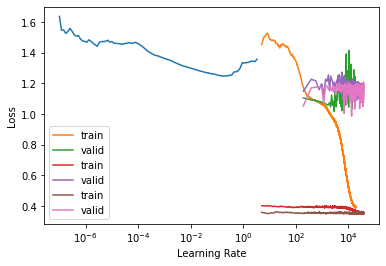

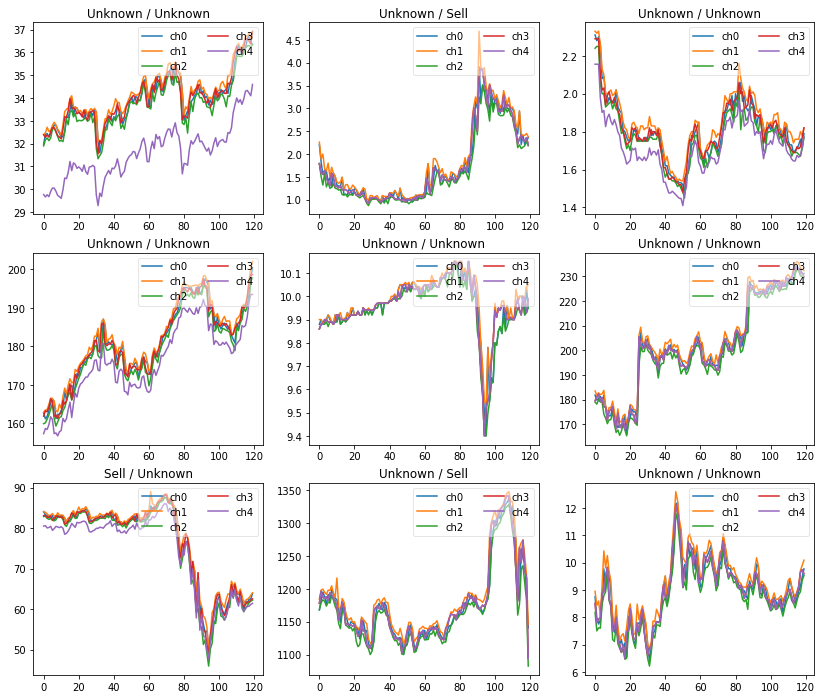

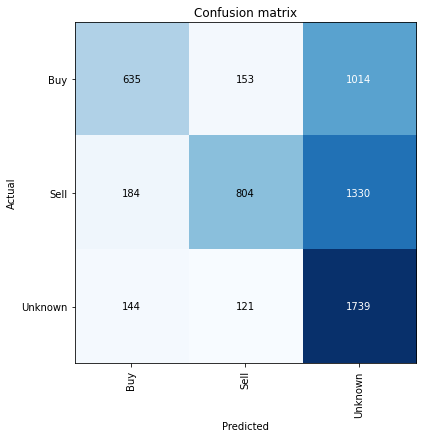

In [14]:
model, learner = train_network(
                                ts_train_fname = ts_train_fname,  # наименования файла для обучения
                                seed = 42, # число которое обеспечивает повторяемость генерации случайных последовтельностей 
                                bs = 128,    # batch size
                                cnt_train_cycles = [100, 200, 200] # число эпох обучения
                                )

In [ ]:
learner.fit_one_cycle(10000, lr_max=1e-4)  # 1e-2
learner.show_results(max_n=9, chs=range(0,5))
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(8,6))


## Получение результатов по Сашиным данным

In [19]:
# def get_val_data():
ts_list = get_stocks_train_dataset(
                                  n = n, # число точек в хвосте временного ряда
                                  k = k, # число точек на которых рассчитывается класс временного ряда
                                  delta = 0.005,  # линия stop loss и 3*delta - линия take profit 
                                  interval = interval, # интервал между точками – [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1d, 5d, 1wk, 1mo, 3mo]
                                  start_date = start_date, # дата от которой происходит отсчет даты назад для генерации временных рядов
                                  step_d = step_d, # шаг по датам от start_date назад чтобы порождать временные ряды
                                  cnt_d = cnt_d, # количество порождаемых дат (назад от start_date) = количество временных рядов на один тикер
                                  ts_fname = ts_test_fname,
                                  input_fname = input_fname, # ссылка на Google-таблицу с исходными данными
                                  sheet_name = 'results',
                                  ds_type = 'val'
  )
df_tickers = get_tickers(gc, input_fname, 'results')
# df_tickers = df_tickers.drop(columns=['model_class', 'fact_class', 'q'])
  
df_fact_class = pd.DataFrame(columns=['ticker', 'fact_class', 'model_class'])
for ts in ts_list:
  df_fact_class = df_fact_class.append({'ticker': ts[2], 'fact_class': ts[1]}, ignore_index=True)

items = get_items_from_arff(ts_test_fname)
predictions = []
for item in items:
  prediction = learner.predict(item[0])[0]
  predictions.append(prediction)
# print(predictions)
df_fact_class['model_class'] = predictions

res_df = df_tickers.merge(df_fact_class, on='ticker', how='outer')
res_df.loc[res_df.model_class == 'Buy', 'model_class'] = 1
res_df.loc[res_df.model_class == 'Sell', 'model_class'] = -1
res_df.loc[res_df.model_class == 'Unknown', 'model_class'] = 0

res_df

Данные с 2016-02-17 по 2020-10-21
[*********************100%***********************]  35 of 35 completed
Общее число временных рядов >>  30
Число рядов для входа в рынок (buy / sel / total)>>  11 2 13
Файл /content/drive/My Drive/20201013_TS_Stocks/20201018_test.arff успешно сфоормирован и сохранен на диск


,ticker,decision_date,input_price,decision,human_class,fact_class,model_class
0,KIRK,2020-10-13,11,Buy,1,1,-1
1,ZGNX,2020-10-13,18.5,Buy,1,1,0
2,BLDR,2020-10-13,34.6,Buy,1,0,1
3,NTRA,2020-10-13,74.5,Buy,1,0,0
4,VLDR,2020-10-13,18.1,Buy,1,NaN,NaN
5,SRNE,2020-10-13,11.65,Buy,1,-1,1
6,CALM,2020-10-13,37.65,Sell,-1,0,0
7,CBOE,2020-10-13,84,Sell,-1,0,0
8,CNK,2020-10-13,8.2,Sell,-1,0,1
9,PZZA,2020-10-13,79.8,Sell,-1,1,0


### Далее идут остатки от первоначального кода по обучению сети и анализу результатов (а также код с 4-мя вариантами построения входного датасета)

## Creating a `Dataloaders` object

In [ ]:
# dsname = 'FINHIST'
fname = Path(ts_train_fname)
fnames = [fname]
# fnames

# Проверяем структуру тренировочного датасета
train_data = TSData.from_arff(fnames)
# print(train_data)
items = train_data.get_items()

# демонстрация графика
# idx = 13
# x1, y1 = train_data.x[idx],  train_data.y[idx]
# y1
# # Test
# show_timeseries(x1, title=y1, chs=[0,1,2,3,4])
# ?show_timeseries(x1, title=y1, chs=range(0,24,3)) # Only the x axis coordinates
seed=42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
# print('Разделение выборки на обучающую и валидационную >> ', splits)

lbl_dict = dict([
  ('-1', 'Sell'),   
  ('0', 'Unknown'),   
  ('1', 'Buy')
  ]
)

tfms = [[ItemGetter(0), ToTensorTS()], [ItemGetter(1), lbl_dict.get, Categorize()]]

# Create a dataset
ds = Datasets(items, tfms, splits=splits) 
# ax = show_at(ds, 2, figsize=(1,1)) #демонстрация примера датасета

### 1st method : using `Datasets` object

In [ ]:
bs = 128                            
# Normalize at batch time
# tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

dls1 = ds.dataloaders(bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

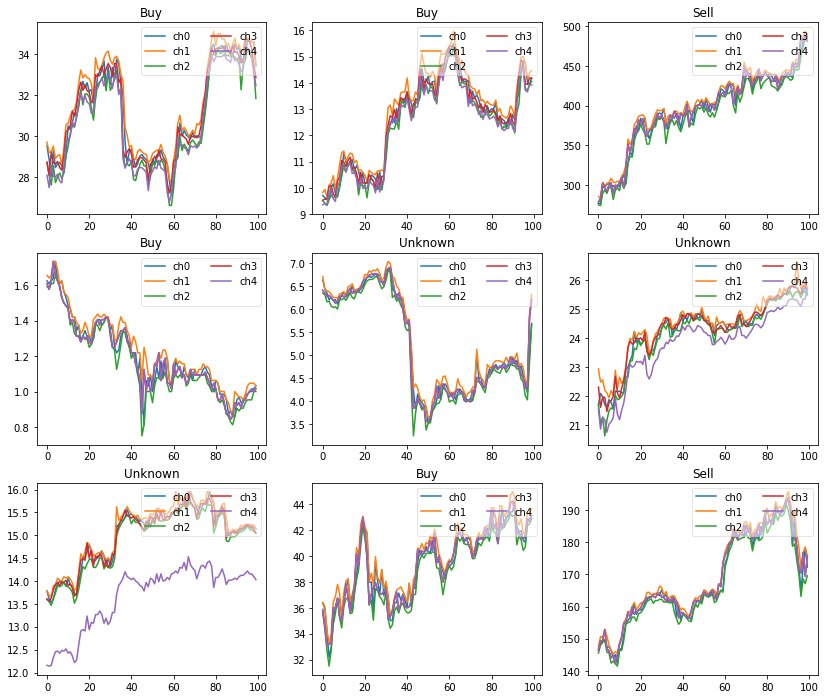

In [ ]:
dls1.show_batch(max_n=9, chs=range(0,5))

# Using `DataBlock` class

### 2nd method : using `DataBlock` and `DataBlock.get_items()` 

In [ ]:
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_items=get_ts_items,
                   get_x = ItemGetter(0),
                   get_y = Pipeline([ItemGetter(1), lbl_dict.get]),
                   splitter=RandomSplitter(seed=seed),
                   batch_tfms = batch_tfms)

In [ ]:
tsdb.summary(fnames)

Setting-up type transforms pipelines
Found 360 items
2 datasets of sizes 288,72
Setting up Pipeline: ItemGetter -> ToTensorTS
Setting up Pipeline: ItemGetter -> dict.get -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ItemGetter -> ToTensorTS
    starting from
      ([[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.363464 -1.390869 ... -1.468123 -1.368706 -1.386574]
 [-0.473406 -0.453322 -0.463813 ... -0.440582 -0.427211 -0.435581]], 2.0)
    applying ItemGetter gives
      [[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.45

In [ ]:
# num_workers=0 is Microsoft Windows
dls2 = tsdb.dataloaders(fnames, num_workers=0, device=default_device())

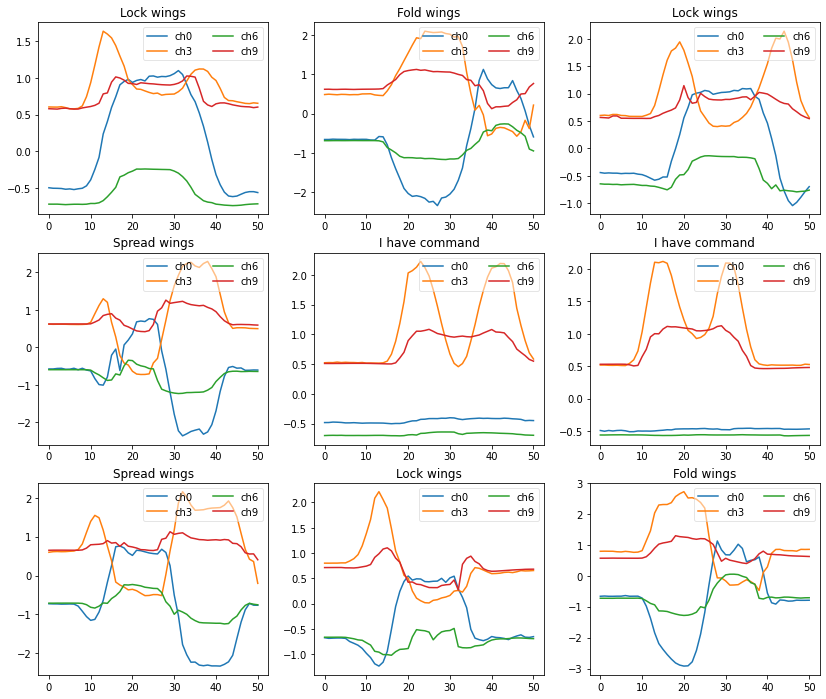

In [ ]:
dls2.show_batch(max_n=9, chs=range(0,12,3))

### 3rd method : using `DataBlock` and passing `items` object to the `DataBlock.dataloaders()`

In [ ]:
# getters = [ItemGetter(0), ItemGetter(1)] 
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_x = ItemGetter(0),
                   get_y = Pipeline([ItemGetter(1), lbl_dict.get]),
                   splitter=RandomSplitter(seed=seed))

In [ ]:
dls3 = tsdb.dataloaders(data.get_items(), batch_tfms=batch_tfms, num_workers=0, device=default_device())

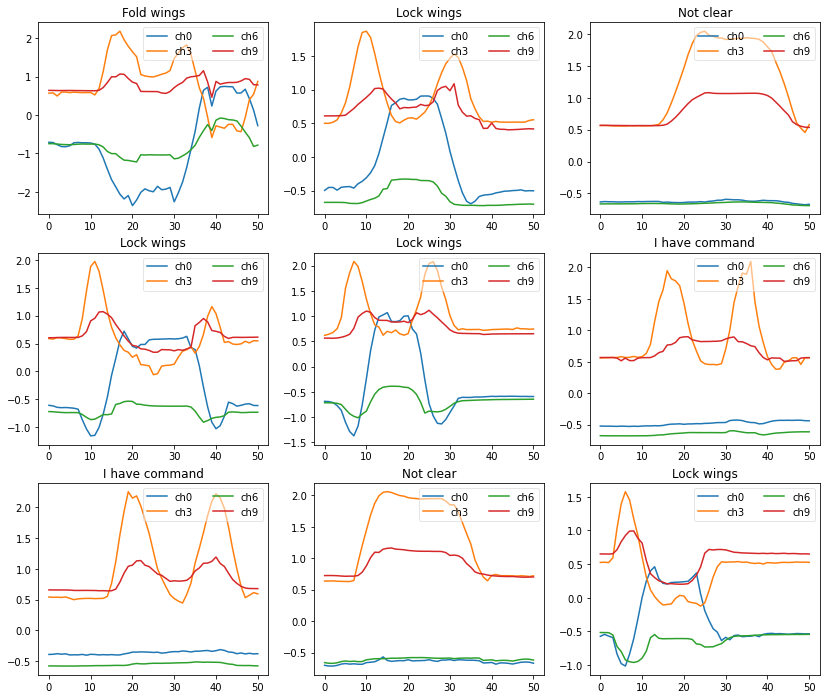

In [ ]:
dls3.show_batch(max_n=9, chs=range(0,12,3))

### 4th method : using `TSDataLoaders` class and `TSDataLoaders.from_files()`

In [ ]:
dls4 = TSDataLoaders.from_files(fnames=fnames, path=path, batch_tfms=batch_tfms, lbl_dict=lbl_dict, num_workers=0, device=default_device())

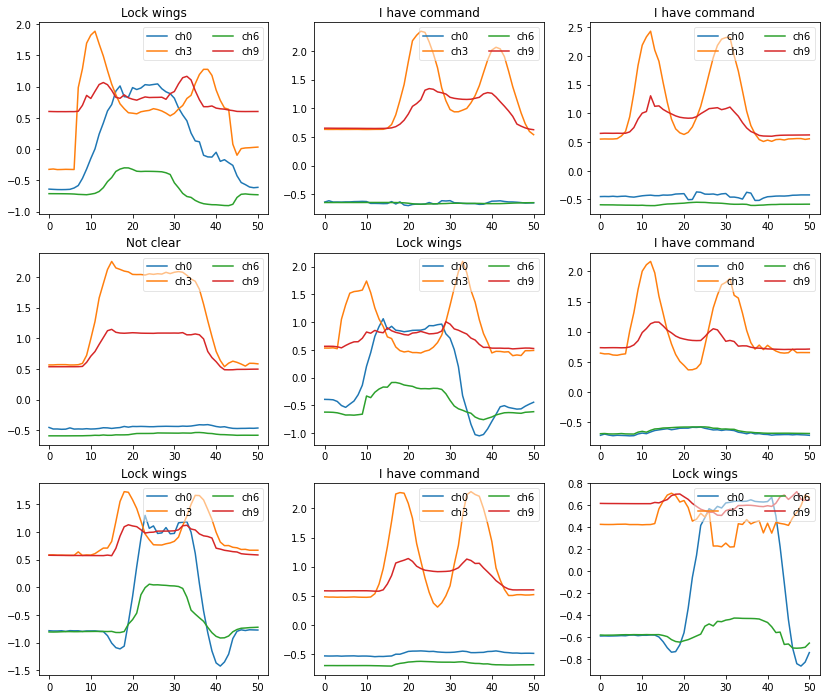

In [ ]:
dls4.show_batch(max_n=9, chs=range(0,12,3))

## Training a Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls1.train) # data.n_channels
# Number of classes
c_out= dls1.c 
c_in,c_out

(6, 3)

### Creating a model

In [ ]:
default_device()

device(type='cuda', index=0)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(6, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(6, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(6, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(6, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), 

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls1, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['128 x 6 x 100'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               128 x 32 x 100       7,488      True      
________________________________________________________________
Conv1d               128 x 32 x 100       3,648      True      
________________________________________________________________
Conv1d               128 x 32 x 100       1,728      True      
________________________________________________________________
MaxPool1d            128 x 6 x 100        0          False     
________________________________________________________________
Conv1d               128 x 32 x 100       192        True      
________________________________________________________________
BatchNorm1d          128 x 128 x 100      256        True      
________________________________________________________________
ReLU                 128 x 128 x 100      0          False     
______________________________________________________

### LR find 

(0.03630780577659607, 7.585775847473997e-07)

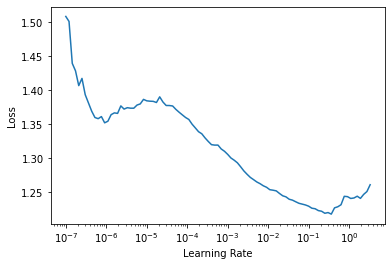

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

### Train

In [ ]:
learn.fit_one_cycle(100, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.095252,1.095249,0.361014,00:03
1,1.095117,1.095172,0.351399,00:03
2,1.095292,1.095092,0.349650,00:03
3,1.095112,1.095030,0.349650,00:03
4,1.094776,1.095019,0.346154,00:03
5,1.094760,1.094904,0.347902,00:03
6,1.094685,1.094887,0.346154,00:03
7,1.094356,1.094676,0.347028,00:03
8,1.094176,1.094541,0.346154,00:03
9,1.093835,1.094448,0.346154,00:03


### Ploting the loss function

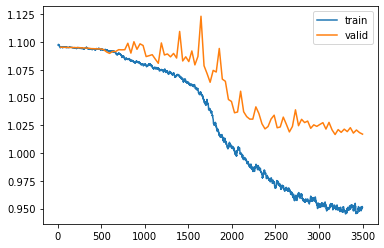

In [ ]:
learn.recorder.plot_loss()

### Showing the results

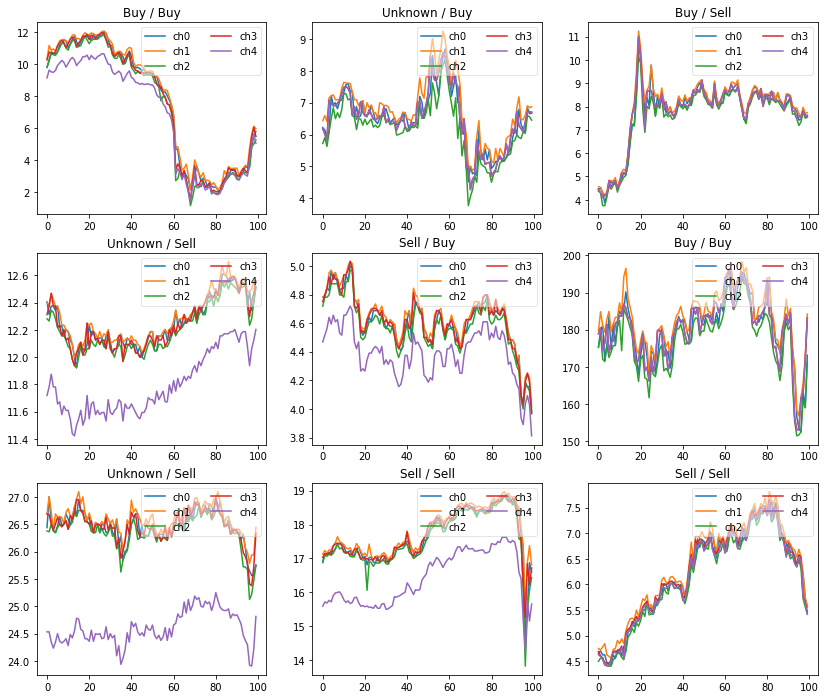

In [ ]:
learn.show_results(max_n=9, chs=range(0,5))

### Showing the confusion matrix

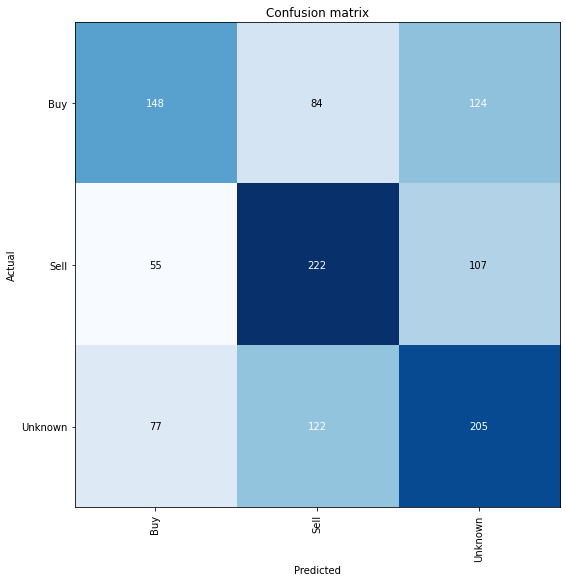

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

![](images/tree.jpg)

In [ ]:
for i in range(100):
  print(learn.predict(items[i][0]))

('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1319, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1319, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5459, 0.1322, 0.3219]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.3757, 0.3371, 0.2872]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1319, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Sell', tensor(1), tensor([0.1749, 0.7040, 0.1211]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))


('Buy', tensor(0), tensor([0.5527, 0.1320, 0.3154]))
